In [1]:
import pandas as pd

df=pd.read_json('https://gist.githubusercontent.com/farhaan-settyl/ecf9c1e7ab7374f18e4400b7a3d2a161/raw/f94652f217eeca83e36dab9d08727caf79ebdecf/dataset.json')

In [2]:
df.head()

,externalStatus,internalStatus
0,PORT OUT,Port Out
1,TERMINAL IN,Inbound Terminal
2,PORT IN,Port In
3,Vessel departure from first POL (Vessel name :...,Departure
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival


In [3]:
df['internalStatus'].value_counts()

internalStatus
Loaded on Vessel            331
Departure                   287
Gate Out                    146
Gate In                     143
Arrival                      62
Empty Return                 47
Empty Container Released     47
Unloaded on Vessel           37
On Rail                      25
Off Rail                     25
Outbound Terminal            24
Port Out                     15
Port In                      14
In-transit                   10
Inbound Terminal              9
Name: count, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Output'] = label_encoder.fit_transform(df['internalStatus'])


In [5]:
!pip install tensorflow keras

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Tokenize and pad text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['externalStatus'])
X = tokenizer.texts_to_sequences(df['externalStatus'])
X = pad_sequences(X, maxlen=130)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['Output'], test_size=0.2, random_state=42)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=500, output_dim=130, input_length=130))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(128,return_sequences=True))

# model.add(LSTM(64,return_sequences=True))

model.add(LSTM(32))

model.add(Dense(15, activation='softmax'))  # Adjust NUM_CLASSES based on the number of unique labels

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=8, epochs=40, validation_data=(X_test, y_test),callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/40
123/123 [==============================] - 12s 58ms/step - loss: 2.1592 - accuracy: 0.2784 - val_loss: 2.2524 - val_accuracy: 0.2449
Epoch 2/40
123/123 [==============================] - 3s 20ms/step - loss: 1.7981 - accuracy: 0.4411 - val_loss: 1.5967 - val_accuracy: 0.5673
Epoch 3/40
123/123 [==============================] - 3s 26ms/step - loss: 1.0370 - accuracy: 0.7584 - val_loss: 0.9656 - val_accuracy: 0.7592
Epoch 4/40
123/123 [==============================] - 3s 22ms/step - loss: 0.6969 - accuracy: 0.8311 - val_loss: 0.8582 - val_accuracy: 0.7959
Epoch 5/40
123/123 [==============================] - 2s 20ms/step - loss: 0.5546 - accuracy: 0.8802 - val_loss: 0.6087 - val_accuracy: 0.8612
Epoch 6/40
123/123 [==============================] - 2s 19ms/step - loss: 0.3965 - accuracy: 0.9191 - val_loss: 0.4589 - val_accuracy: 0.8980
Epoch 7/40
123/123 [==============================] - 2s 20ms/step - loss: 0.3031 - accuracy: 0.9376 - val_loss: 0.3614 - val_accuracy: 0.918

In [16]:

def predict_internal_status(model, tokenizer, user_input):
    # Tokenize the user input
    import numpy as np
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    # Pad sequences to the same length as training data
    user_input_sequence_padded = pad_sequences(user_input_sequence, maxlen=130)

    # Make predictions
    predictions = model.predict(user_input_sequence_padded)
    # Get the predicted class (internal status)
    predicted_class = np.argmax(predictions)
    predicted_class = label_encoder.inverse_transform([predicted_class])

    return predicted_class[0]
    # return predicted_class

In [23]:
predict_internal_status(model,tokenizer,'  passed toll plazza')

1/1 [==============================] - 0s 22ms/step


'In-transit'

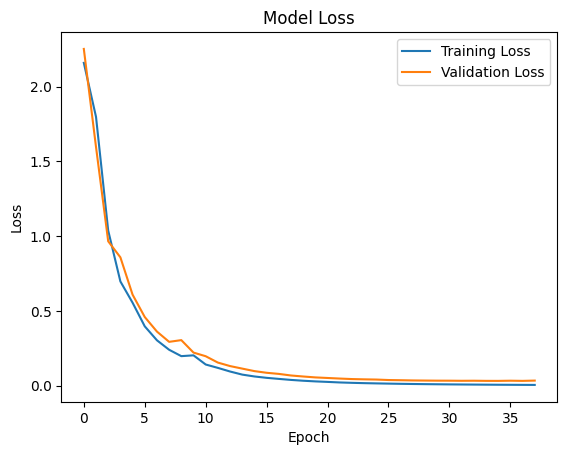

In [24]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming `history` is the variable containing the training history of the model
plot_loss(history)

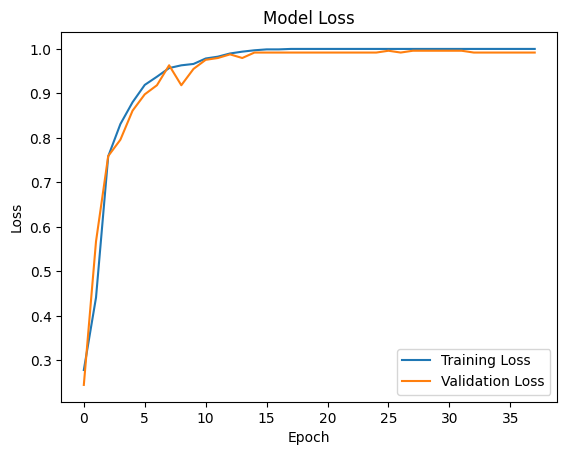

In [25]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Loss')
    plt.plot(history.history['val_accuracy'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming `history` is the variable containing the training history of the model
plot_accuracy(history)

In [27]:
model.save('./model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [30]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)